# Production notebook

In [1]:
#TODO: delete cell
##enables reload of modules 
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
#custom utilities: 
parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)
from utils import config
from utils.config import *
from utils import datawrangler
from utils.preflight import *
from utils.plotstyle import *
from utils.production import *
initialize_custom_style()

In [3]:
##configurable stuff: read the file, asign it to variables: 
binamount = 50
root_dir = config.get_root_dir()
config_dict = config.readconfig(os.path.join(root_dir, 'config/config_production.json'))
data_dir = os.path.join(root_dir, config_dict['data_dir'])
print(config_dict)

{'data_dir': 'data/rawdata/full/data_productie', 'masterfile': 'master_data.json', 'dailydirname': 'daily_production'}


## reading data in Python:

In [4]:

#load all the data required for this task. 
#masterfile
master_production_data= pd.read_json(os.path.join(root_dir, config_dict['data_dir'], config_dict['masterfile']), typ='series')
production_data = pd.DataFrame(load_json_datafiles(os.path.join(root_dir, config_dict['data_dir'], config_dict['dailydirname'])))


In [5]:
# production_data.query("facility == 'BRU' and maintenance == 'No' and production == 0").shape[0]

In [6]:
# production_data.query("facility == 'BRU' and maintenance == 'No' and production != 0").shape[0]


In [7]:
# production_data.query("facility == 'BRU' and maintenance == 'No'").shape[0]


In [8]:
# 308/1428

## Inspecting read data

In [9]:
preflightchecks(production_data)
#not that great, but:
#   we learned that not a single column is truely unique!
#   maintainece is to be considered a boolean.
#   some values that should be ints, are objects! Why? 


,Column Name,Data Type,NaN Count,Unique Count,suitable PK,Max,Min,Range,Avg,Median,Mode,Standard Dev,Variance,Skewedness,Kurtosis,Quant_25,Quant_50,Quant_75,Out of bound lows,Out of bound highs
0,DoW,object,0,7,False,NaN,NaN,NaN,NaN,NaN,Monday,NaN,NaN,NaN,NaN,None,None,None,None,None
1,hour,int64,0,1,False,1.0,1.0,0.0,1.0,1.0,1,0.0,0.0,0.0,0.0,"0.25 1.0 Name: hour, dtype: float64","0.5 1.0 Name: hour, dtype: float64","0.75 1.0 Name: hour, dtype: float64",None,None
2,minute,int64,0,1,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,"0.25 0.0 Name: minute, dtype: float64","0.5 0.0 Name: minute, dtype: float64","0.75 0.0 Name: minute, dtype: float64",None,None
3,date,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,01-01-2018 00:00:00.0000,NaN,NaN,NaN,NaN,None,None,None,None,None
4,maintenance,object,0,2,False,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,None,None,None,None,None
5,prod_loss,object,0,434,False,NaN,NaN,NaN,NaN,NaN,1244,NaN,NaN,NaN,NaN,None,None,None,None,None
6,prod_loss_perc,object,0,94,False,NaN,NaN,NaN,NaN,NaN,100,NaN,NaN,NaN,NaN,None,None,None,None,None
7,production,object,0,581,False,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,None,None,None,None,None
8,sourcefile,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,20180101.json,NaN,NaN,NaN,NaN,None,None,None,None,None
9,facility,object,0,2,False,NaN,NaN,NaN,NaN,NaN,BRU,NaN,NaN,NaN,NaN,None,None,None,None,None


In [10]:
#drop data for days where there's planned maintenance:
production_data_no_maintenance = production_data.query("maintenance == 'No'").copy()
#convert columns to ints where appropriate:
to_int_columns = ['prod_loss', 'prod_loss_perc', 'production']
for col in to_int_columns: 
    production_data_no_maintenance[col] = production_data_no_maintenance[col].astype('int')
    

In [11]:
preflightchecks(production_data_no_maintenance)

,Column Name,Data Type,NaN Count,Unique Count,suitable PK,Max,Min,Range,Avg,Median,Mode,Standard Dev,Variance,Skewedness,Kurtosis,Quant_25,Quant_50,Quant_75,Out of bound lows,Out of bound highs
0,DoW,object,0,7,False,NaN,NaN,NaN,NaN,NaN,Monday,NaN,NaN,NaN,NaN,None,None,None,None,None
1,hour,int64,0,1,False,1.0,1.0,0.0,1.000000,1.0,1,0.000000,0.000000,0.000000,0.000000,"0.25 1.0 Name: hour, dtype: float64","0.5 1.0 Name: hour, dtype: float64","0.75 1.0 Name: hour, dtype: float64",None,None
2,minute,int64,0,1,False,0.0,0.0,0.0,0.000000,0.0,0,0.000000,0.000000,0.000000,0.000000,"0.25 0.0 Name: minute, dtype: float64","0.5 0.0 Name: minute, dtype: float64","0.75 0.0 Name: minute, dtype: float64",None,None
3,date,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,01-01-2018 00:00:00.0000,NaN,NaN,NaN,NaN,None,None,None,None,None
4,maintenance,object,0,1,False,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,None,None,None,None,None
5,prod_loss,int32,0,433,False,1244.0,9.0,1235.0,264.636443,159.0,1244,326.334440,106494.166542,2.344464,4.342576,"0.25 73.0 Name: prod_loss, dtype: float64","0.5 159.0 Name: prod_loss, dtype: float64","0.75 274.0 Name: prod_loss, dtype: float64",None,None
6,prod_loss_perc,int32,0,93,False,100.0,3.0,97.0,35.002028,25.0,100,27.561186,759.618947,1.645627,1.232245,"0.25 20.0 Name: prod_loss_perc, dtype: float64","0.5 25.0 Name: prod_loss_perc, dtype: float64","0.75 32.0 Name: prod_loss_perc, dtype: float64",None,None
7,production,int32,0,580,False,1193.0,0.0,1193.0,497.173523,215.0,0,424.405019,180119.620127,0.343864,-1.690923,"0.25 191.0 Name: production, dtype: float64","0.5 215.0 Name: production, dtype: float64","0.75 974.0 Name: production, dtype: float64",None,None
8,sourcefile,object,0,1830,False,NaN,NaN,NaN,NaN,NaN,20180101.json,NaN,NaN,NaN,NaN,None,None,None,None,None
9,facility,object,0,2,False,NaN,NaN,NaN,NaN,NaN,BRU,NaN,NaN,NaN,NaN,None,None,None,None,None


In [12]:

print(master_production_data)
for facility, group in production_data_no_maintenance.groupby('facility'):
    print(group.production.max(), group.production.min(), group.production.mean())

BRU msr    1244
STO msr     274
dtype: int64
1193 0 813.7119815668203
265 0 176.9458041958042


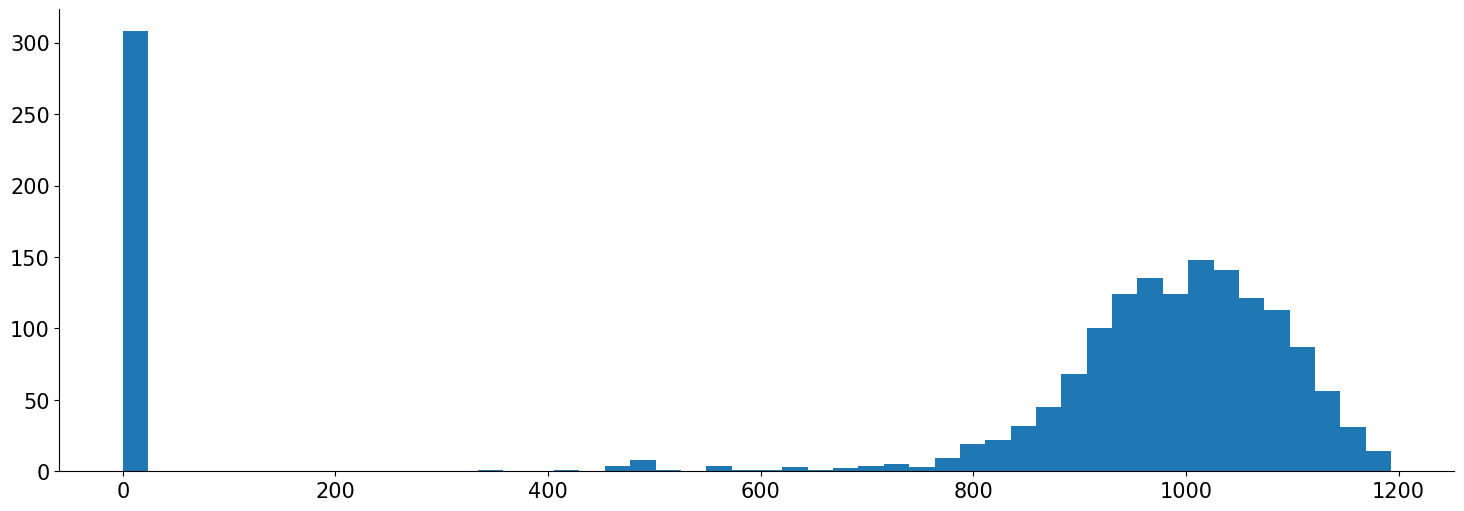

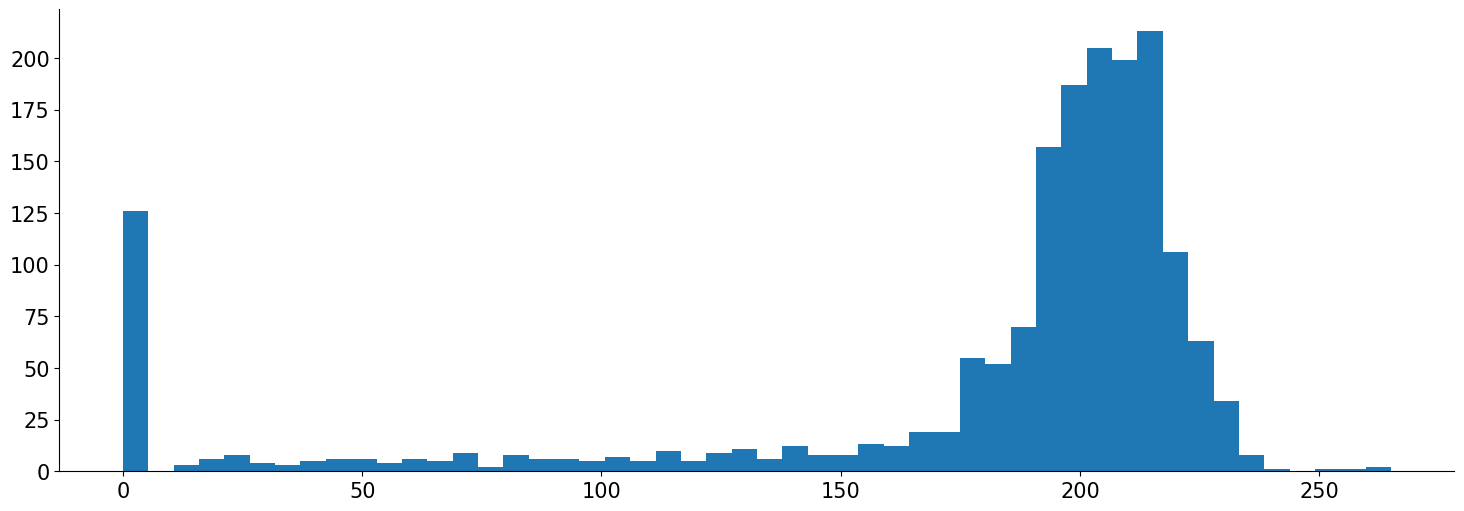

In [13]:
#what's the chance of NO PRODUCITON per facility IGNORING maintenance: 
no_production_chance = {}
for facility, group in production_data_no_maintenance.groupby('facility'): 
    ##you need to extract the ratio of days with UNPLANNED zero production over the total days of planned production
    no_production_chance[facility] = group.query('production == 0').shape[0]/group.shape[0]
    #to have an idea of what we should be targetting in our data: 
    group.production.hist(bins = binamount, grid = False)
    plt.show()


In [14]:

no_production_days = production_data_no_maintenance.query("production == 0")
production_days = production_data_no_maintenance.query("production > 0")

In [15]:
predictions_per_facility = {}
for facility, group in production_days.groupby('facility'): 
    predictions_per_facility[facility] = norm.fit(group['production'])


In [16]:
def simulate(facilitycode, n_days): 
    production = []
    delta = 10 ** -6
    for _ in range(n_days): 
        #get the chance of total failure at facility:
        catastrophe = no_production_chance[facilitycode]
        chance_of_catastrophe = np.random.rand() 
        if catastrophe - chance_of_catastrophe > delta:
            #total fuck up :)
            production.append(0)
        else:
            mean, stdev = predictions_per_facility[facilitycode]
            result_of_scipy = norm.rvs(loc=mean, scale=stdev, size=1)[0]
            production.append(result_of_scipy)
    return production

def merged_production(*all_production_lists): 
    """Takes as argument a single list of multiple sublists. Each sublist
    is the projected production for a single factory. The function returns
    the expected production across all locations."""
    max_length = max(map(len, all_production_lists))
    sum_over_list = [sum(prod) for prod in zip(*[lst + [0]*(max_length - len(lst)) for lst in all_production_lists])]
    return sum_over_list

def get_prod_estimate_per_facility(ndays, reduced = True): 
    """required ndays argument = int: how many days do you want
    to include in the projection. 
    reduced = optional bool = (default = true): Set to false to 
    return a dict with precise production per facility. If reduece
    is true, it will return a list without keys to indicate each 
    location's output. 
    """
    facilities_production = {}
    for location in master_production_data.keys():
        loc = location.split(' ')[0]
        facilities_production[loc] = simulate(loc, ndays)
    if reduced:
        return list(facilities_production.values())
    else:
        return facilities_production
       


In [17]:

brures = simulate('BRU', 100000)
stores = simulate('STO', 100000)


In [18]:
#cool, brures and stores have a predicted fuck up rate that is close enough
#to the actual fuck up rates! so that part is good enough.
print(brures.count(0)/100000, no_production_chance['BRU'])
print(stores.count(0)/100000, no_production_chance['STO'])



0.17854 0.1774193548387097
0.07423 0.07342657342657342


In [19]:
#see if brures and stores have a similar mean as the observed result for bru and sto: 
print(sum(brures)/len(brures), production_data_no_maintenance.query('facility=="BRU"').production.mean() )
print(sum(stores)/len(stores), production_data_no_maintenance.query('facility=="STO"').production.mean() )


812.7332425335271 813.7119815668203
177.02297996298242 176.9458041958042


<Axes: ylabel='Frequency'>

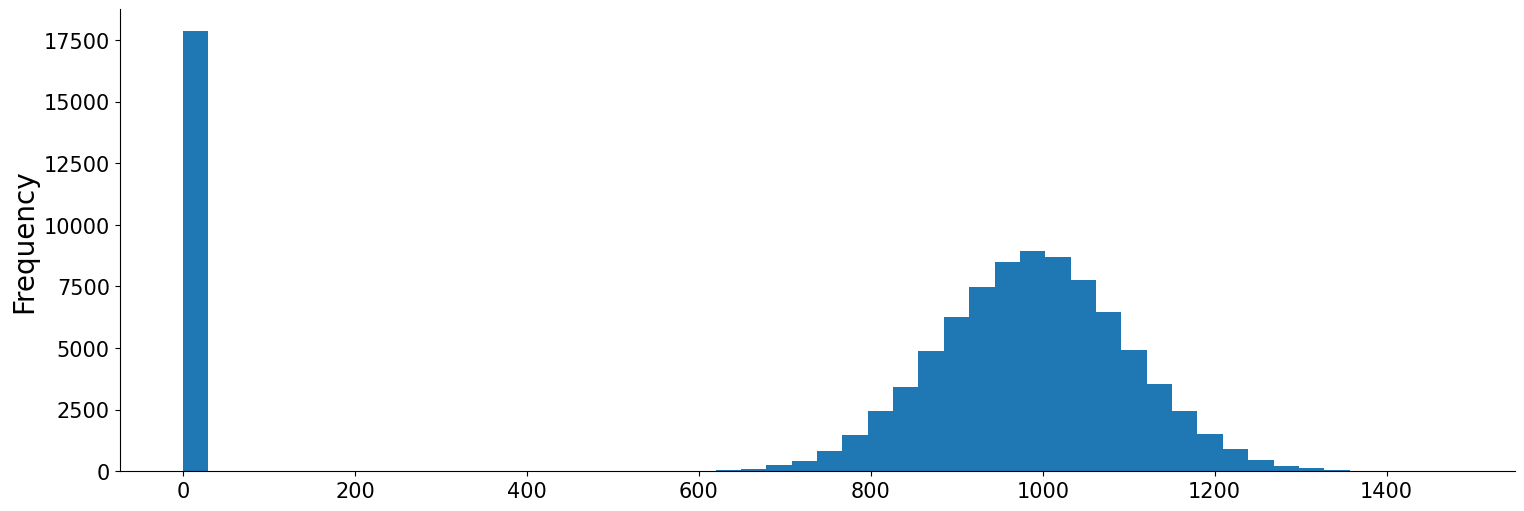

In [20]:
pd.Series(brures).plot.hist(bins =50)

<Axes: ylabel='Frequency'>

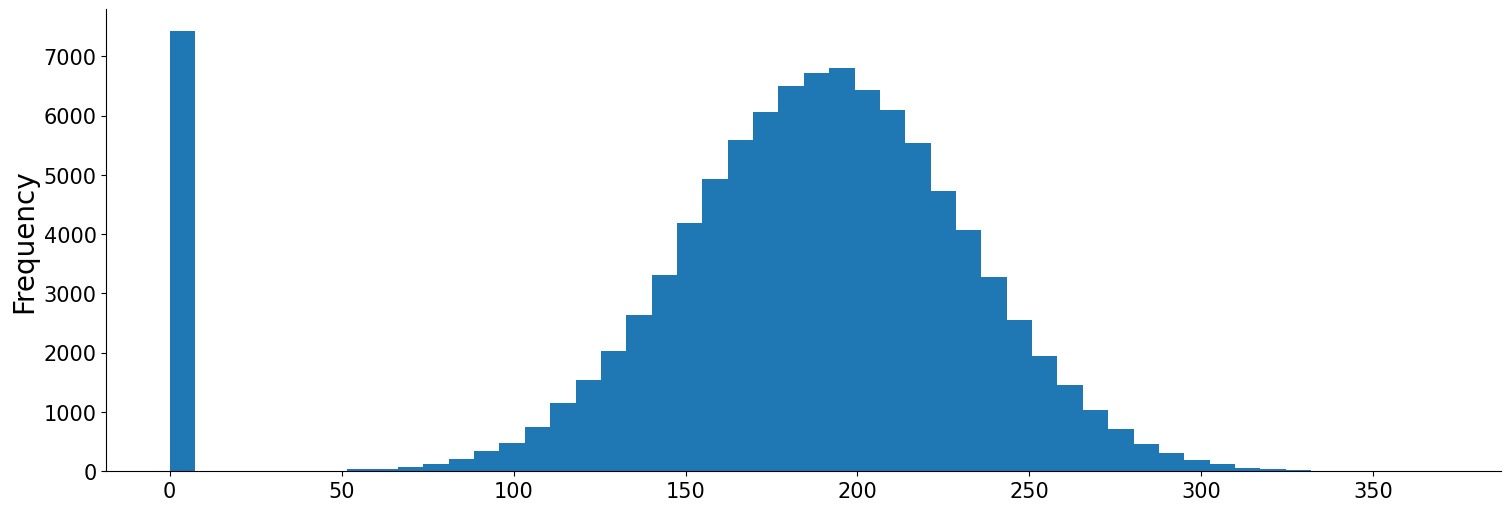

In [21]:
pd.Series(stores).plot.hist(bins =50)

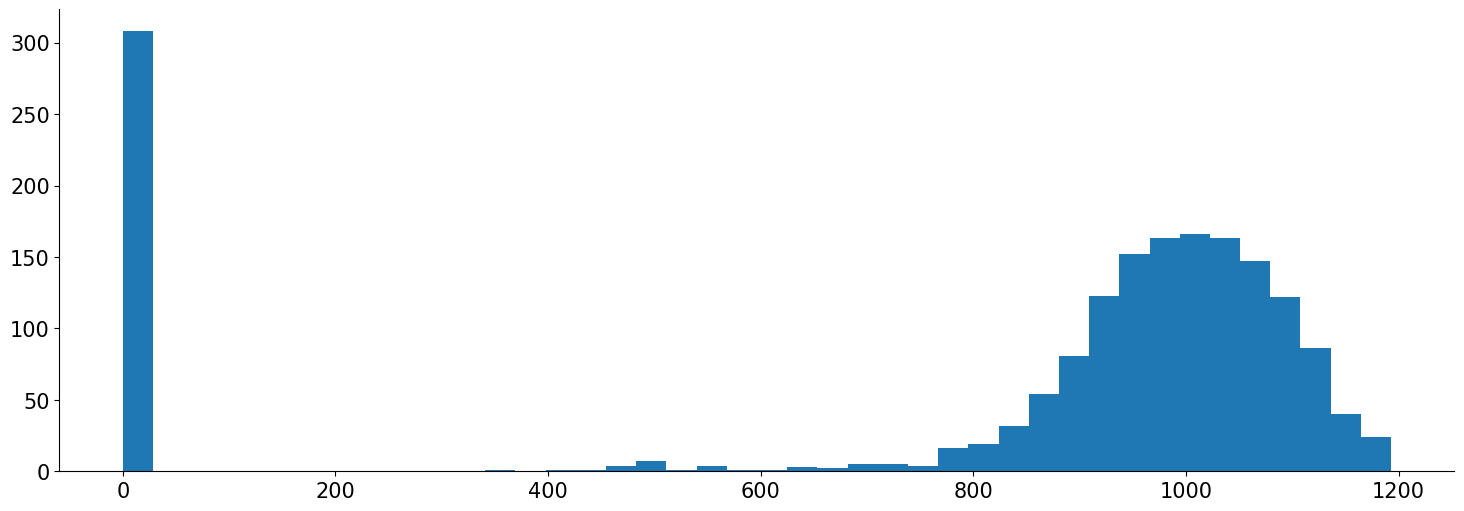

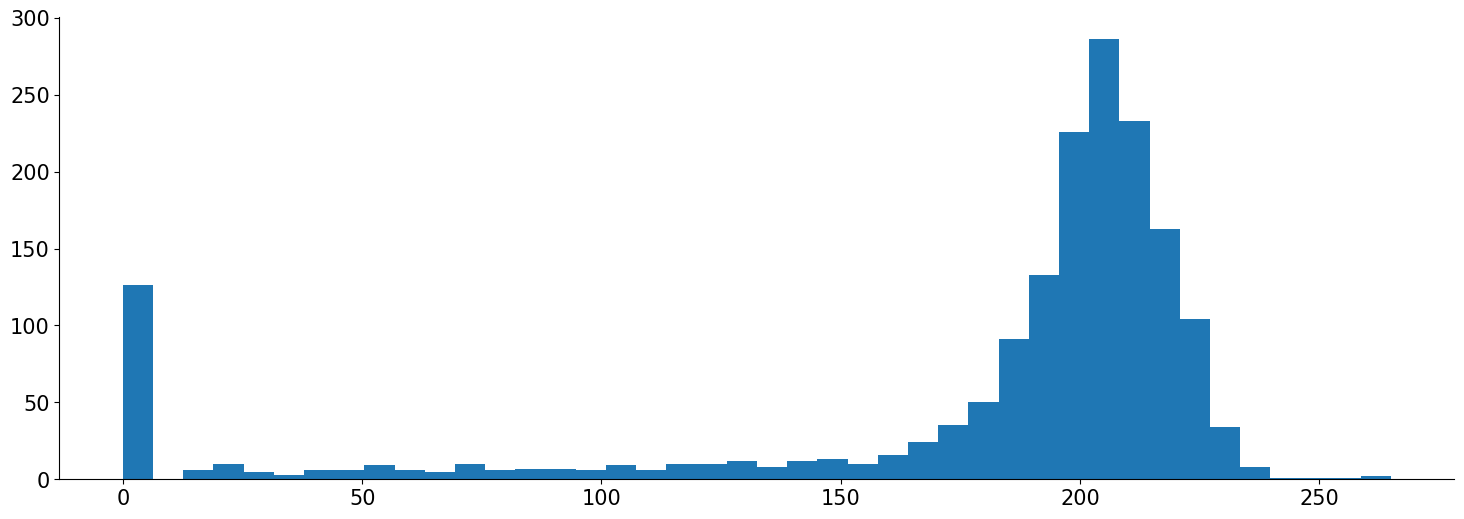

In [22]:
for facility, group in production_data_no_maintenance.groupby('facility'):
    group.production.hist(
        bins = int(np.ceil(np.sqrt(group.shape[0]))), 
        grid = False)
    plt.show()

## DEEL 7

Gebruik je simulatieprogramma om de productiekansen over een periode van n dagen te simuleren. Maak
ook een grafiek waarin je de vorm van de empirische cdf: $$F(x) = P{X_n \leq x},$$ met $X_n$ de willekeurige
variabele die gelijk is aan de productie over $n$ (i.i.d.) dagen. Voor het bepalen van de ecdf kan je gebruik
maken van de functie scipy.stats.ecdf.
Pas je functie ook eens toe op een periode van 7 dagen. Je code zou er ongeveer zo uit moeten zien:
import matplotlib.pyplot als plt
import numpy als np
xx = np.linspace(0, 10 ** 4)
data = simulation(7)
Fxx = cumulatieve_distribution_function(xx)
plt.plot(xx, Fxx)


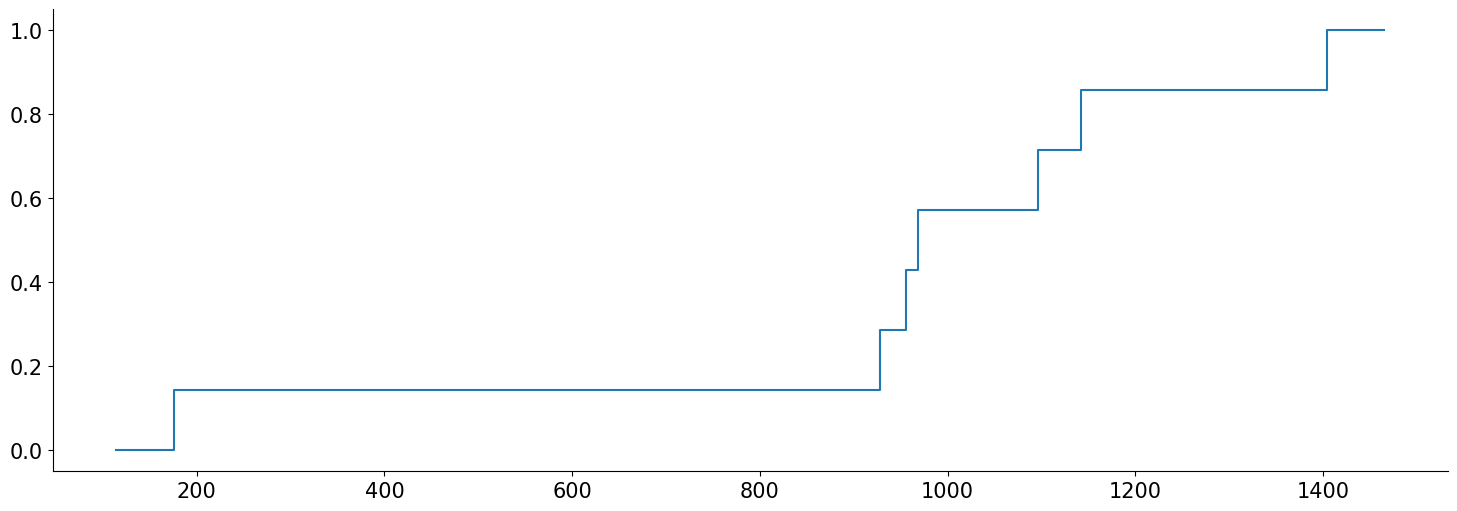

In [23]:
#TODO: ask.

forecast_horizon = 7
# Step1 simulate for x days for both sites: 
forecast_data_per_factory = get_prod_estimate_per_facility(forecast_horizon)
forecast_data_total = merged_production(*forecast_data_per_factory)
# Step 2: Get the ECDF for the forecasted data: 
ecdf_forecast = ecdf(forecast_data_total)
ecdf_forecast.cdf.plot()

## Central Limit Theoream   

Bekijk de verdeling die je bepaalde in de vorige stap. Deze geeft je de verdeling van de productie over een
aantal dagen. De centrale limietstelling zegt dat als je een groot aantal onafhankelijke waarnemingen samen
normaal verdeeld zijn. Kan je deze observatie visueel voorstellen door de empirische cdf te vergelijken met de
theoretische cdf van de normale verdeling, dit voor een stijgend aantal dagen n die je accumuleert?

In [24]:

brures_large = simulate('BRU', 1000000)
stores_large = simulate('STO', 1000000)

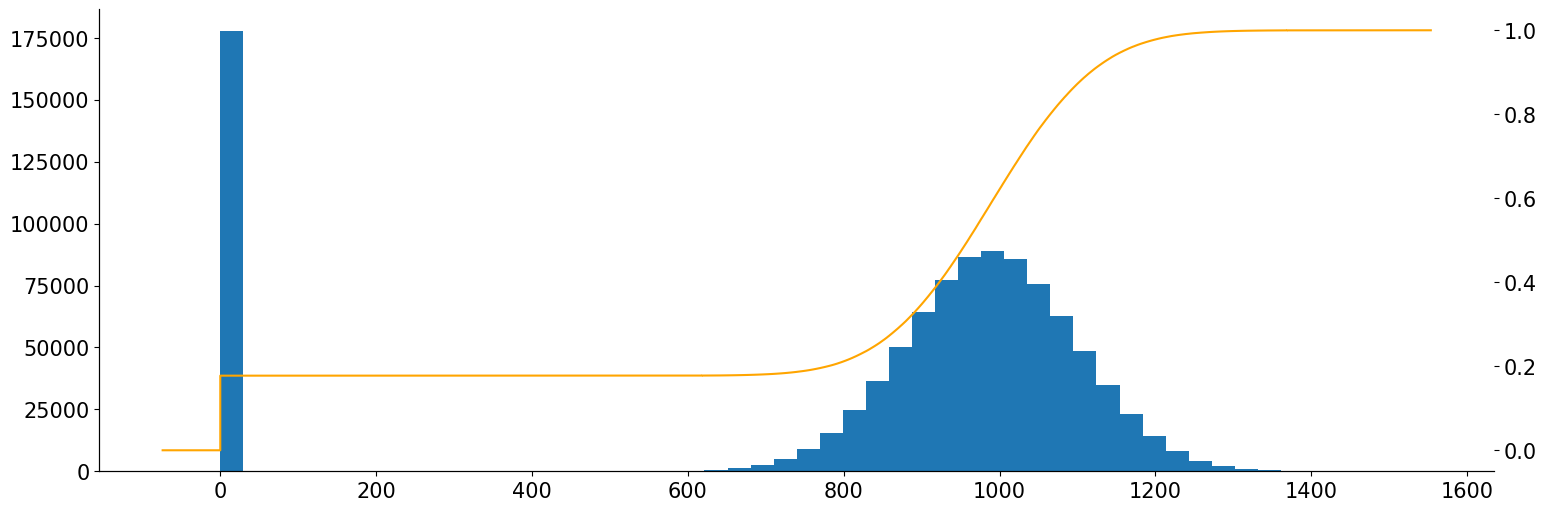

In [25]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.hist(
    brures_large, 
    bins = binamount
    )

ecdf(brures_large).cdf.plot(ax2, color='orange')

# pd.Series(brures_large).plot.hist(bins =50)
# brures_large_ecdf = 

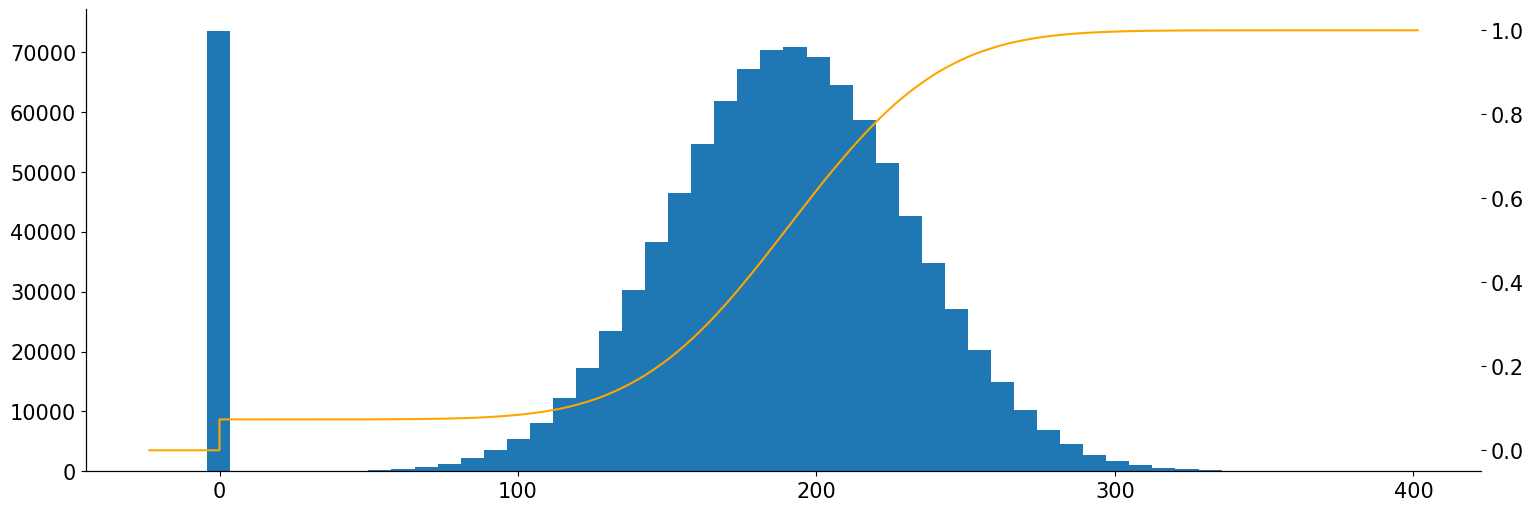

In [26]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.hist(
    stores_large, 
    bins=50
    )

ecdf(stores_large).cdf.plot(ax2, color='orange')